In [1]:
"""
To prepare the starter code, copy this file over to decision_tree_starter.py
and go through and handle all the inline TODOs.
"""
from collections import Counter

import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
import pandas as pd
from pydot import graph_from_dot_data
import io

import random
random.seed(246810)
np.random.seed(246810)

eps = 1e-5  # a small number


In [2]:

class DecisionTree:

    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def entropy(y):
        # TODO
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        p = counts/counts.sum()

        return -np.sum(p * np.log2(p + eps)) #add eps to avoid log(0)

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO
        cur_entropy = DecisionTree.entropy(y)
        left = X < thresh
        right = ~left
        y_left = y[left]
        y_right = y[right]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0
        
        left_entropy = DecisionTree.entropy(y_left)
        right_entropy = DecisionTree.entropy(y_right)

        weighted_entropy = (len(y_left) / len(y)) * left_entropy + (len(y_right) / len(y)) * right_entropy

        return cur_entropy - weighted_entropy

    @staticmethod
    def gini_impurity(X, y, thresh):
        # OPTIONAL
        pass

    @staticmethod
    def gini_purification(X, y, thresh):
        # OPTIONAL
        pass

    def split(self, X, y, feature_idx, thresh):
        """
        Split the dataset into two subsets, given a feature and a threshold.
        Return X_0, y_0, X_1, y_1
        where (X_0, y_0) are the subset of examples whose feature_idx-th feature
        is less than thresh, and (X_1, y_1) are the other examples.
        """
        # TODO
        left = X[:, feature_idx] < thresh
        right = ~left 
        X_left = X[left]
        y_left = y[left]
        X_right = X[right]
        y_right = y[right]
        return X_left, y_left, X_right, y_right

    def fit(self, X, y):
        # TODO
        self.labels = y

        #if hit max depth or all same labels
        if self.max_depth == 0 or len(np.unique(y)) == 1:
            self.pred = Counter(y).most_common(1)[0][0]
            return

        best_info_gain = -np.inf
        best_feature_idx = None
        best_thresh = None
        best_splits = None


        for i in range(X.shape[1]):

            values = np.unique(X[:, i])
            if len(values) <= 1:
                continue
            for j in range(len(values) - 1): 
                thresh = (values[j] + values[j + 1]) / 2
                curr_gain = DecisionTree.information_gain(X[:, i], y, thresh)
                if curr_gain > best_info_gain:
                    best_info_gain = curr_gain
                    best_feature_idx = i
                    best_thresh = thresh
                    best_splits = self.split(X, y, i, thresh)

        if best_info_gain <= 0 or best_splits is None:
            self.pred = Counter(y).most_common(1)[0][0]
            return

        self.split_idx = best_feature_idx
        self.thresh = best_thresh

        X_left, y_left, X_right, y_right = best_splits
        self.left = DecisionTree(self.max_depth - 1, self.features)
        self.left.fit(X_left, y_left)
        self.right = DecisionTree(self.max_depth - 1, self.features)
        self.right.fit(X_right, y_right)

    def predict(self, X):
        # TODO
        res = []
        for x in X:
            node = self
            while node.pred is None:
                if x[node.split_idx] < node.thresh:
                    node = node.left
                else:
                    node = node.right
            res.append(node.pred)
        return np.array(res)
    
    
    def _to_graphviz(self, node_id):
        # If this node is a leaf, indicated by self.pred being set, then just show the prediction.
        if self.pred is not None:
            return f'{node_id} [label="Prediction: {self.pred}\nSamples: {len(self.labels)}"];\n'
        else:
            graph = f'{node_id} [label="{self.features[self.split_idx]} < {self.thresh:.2f}"];\n'
            left_id = node_id * 2 + 1
            right_id = node_id * 2 + 2
            if self.left is not None:
                graph += f'{node_id} -> {left_id};\n'
                graph += self.left._to_graphviz(left_id)
            if self.right is not None:
                graph += f'{node_id} -> {right_id};\n'
                graph += self.right._to_graphviz(right_id)
            return graph


    def to_graphviz(self):
        graph = "digraph Tree {\nnode [shape=box];\n"
        graph += self._to_graphviz(0)
        graph += "}\n"
        return graph
        
    def __repr__(self):
        # If this node is a leaf, self.pred will be set.
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        if self.pred is not None:
            return "%s (%s)" % (self.pred, len(self.labels))
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                        self.thresh, self.left.__repr__(),
                                        self.right.__repr__())

In [3]:

class BaggedTrees(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO
        n_samples = X.shape[0]
        for tree in self.decision_trees:
            bootstrap_idx = np.random.choice(n_samples, size=n_samples, replace=True)
            X_bootstrap = X[bootstrap_idx]
            y_bootstrap = y[bootstrap_idx]
            tree.fit(X_bootstrap, y_bootstrap)

    def predict(self, X):
        # TODO
        all_preds = np.array([tree.predict(X) for tree in self.decision_trees])
        all_preds = all_preds.T  
        votes = []
        for row in all_preds:
            votes.append(Counter(row).most_common(1)[0][0])
        return np.array(votes)
    


class RandomForest(BaggedTrees):

    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        params['max_features'] = m
        self.m = m
        super().__init__(params=params, n=n)

In [4]:


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    data = np.array(data, dtype=str)
    # Replace empty strings with the placeholder '-1'
    data[data == ''] = '-1'
    
    # One-hot encode specified columns
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term, freq in counter.most_common():
            if term == '-1': 
                continue
            if freq <= min_freq:
                break
            onehot_features.append(term)
            onehot_encoding.append((data[:, col] == term).astype(float))
        data[:, col] = '0'
    
    if len(onehot_encoding) > 0:
        onehot_encoding = np.array(onehot_encoding).T
    else:
        onehot_encoding = np.empty((data.shape[0], 0))
    data_numeric = np.array(data, dtype=float)
    
    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        # TODO
        for i in range(data_numeric.shape[1]):
    
            missing = np.abs(data_numeric[:, i] + 1) < eps
            non_missing = data_numeric[~missing, i]
            if non_missing.size == 0:
                continue 
          
            non_missing = np.array(non_missing)
            
            if non_missing.ndim == 0 or non_missing.size == 1:
                mode_val = non_missing.item()
            else:
                counts = Counter(non_missing)
                mode_val = counts.most_common(1)[0][0]

            data_numeric[missing, i] = mode_val
    
    final_data = np.hstack([data_numeric, onehot_encoding])
    
    return final_data, onehot_features


def evaluate(clf):
    print("Cross validation", cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)


def generate_submission(testing_data, predictions, dataset="titanic"):
    assert dataset in ["titanic", "spam"], f"dataset should be either 'titanic' or 'spam'"
    # This code below will generate the predictions.csv file.
    if isinstance(predictions, np.ndarray):
        predictions = predictions.astype(int)
    else:
        predictions = np.array(predictions, dtype=int)
    assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
    df = pd.DataFrame({'Category': predictions})
    df.index += 1  # Ensures that the index starts at 1.
    df.to_csv(f'predictions_{dataset}.csv', index_label='Id')

In [ ]:
dataset = "spam"
params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
}
N = 100

if dataset == "spam":
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
    ]
    assert len(features) == 32

    # Load spam data from the .mat file
    path_train = 'datasets/spam_data/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    Z = data['test_data']
    class_names = ["Ham", "Spam"]
else:
    raise NotImplementedError("Dataset %s not handled" % dataset)

print("Features", features)
print("Train/test size", X.shape, Z.shape)

# Decision Tree (for visualization/debugging)
print("\n\nDecision Tree")
dt = DecisionTree(max_depth=3, feature_labels=features)
dt.fit(X, y)
print("\n\nTree Structure")
print(dt.__repr__())
graph_from_dot_data(dt.to_graphviz())[0].write_pdf("%s-basic-tree.pdf" % dataset)

# Random Forest (final model)
print("\n\nRandom Forest")
rf = RandomForest(params, n=N, m=int(np.sqrt(X.shape[1])))
rf.fit(X, y)
evaluate(rf)

# Hyperparameter tuning using a simple for-loop over max_depth and min_samples_leaf:
max_depth_candidates = [3, 5, 10, 15, 20, 30]
min_samples_leaf_candidates = [5, 10, 15]

best_cv_score = -np.inf
best_params = None

for max_depth in max_depth_candidates:
    for min_samples_leaf in min_samples_leaf_candidates:
        params['max_depth'] = max_depth
        params['min_samples_leaf'] = min_samples_leaf
        rf_temp = RandomForest(params=params, n=N, m=int(np.sqrt(X.shape[1])))
        rf_temp.fit(X, y)
        cv_scores = cross_val_score(rf_temp, X, y, cv=5)
        avg_cv_score = np.mean(cv_scores)
        
        print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, CV Score: {avg_cv_score:.4f}")
        
        if avg_cv_score > best_cv_score:
            best_cv_score = avg_cv_score
            best_params = (max_depth, min_samples_leaf)

print("\nBest Hyperparameters:")
print(f"max_depth: {best_params[0]}, min_samples_leaf: {best_params[1]}, with CV Score: {best_cv_score:.4f}")

rf_best = RandomForest(params={'max_depth': best_params[0], 'min_samples_leaf': best_params[1]}, n=N, m=int(np.sqrt(X.shape[1])))
rf_best.fit(X, y)
pred = rf_best.predict(Z)
generate_submission(Z, pred, dataset)

Features ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size (5172, 32) (5857, 32)


Decision Tree


Tree Structure
[exclamation < 0.5: [meter < 0.5: [parenthesis < 0.5: 0 (2060) | 0 (1169)] | 0 (688)] | [meter < 0.5: [ampersand < 0.5: 1 (1043) | 0 (127)] | 0 (85)]]


Random Forest
Cross validation [0.79323671 0.82898551 0.81237911 0.7901354  0.80464217]
First splits [('money', 16), ('meter', 14), ('exclamation', 13), ('pain', 8), ('volumes', 7), ('featured', 7), ('spam', 6), ('dollar', 6), ('parenthesis', 6), ('ampersand', 5), ('prescription', 4), ('sharp', 2), ('creative', 2), ('private', 1), ('differ', 1), ('revision', 1), ('business', 1)]
max_depth: 3, min_samples_leaf: 5, CV Sc

In [ ]:
#do the same with titanic
dataset = "titanic"
# dataset = "spam"
params = {
    "max_depth": 5,
    # "random_state": 6,
    "min_samples_leaf": 10,
}
N = 100

if dataset == "titanic":
    # Load titanic data
    path_train = 'datasets/titanic/titanic_training.csv'
    data = genfromtxt(path_train, delimiter=',', dtype=None)
    path_test = 'datasets/titanic/titanic_testing_data.csv'
    test_data = genfromtxt(path_test, delimiter=',', dtype=None)
    y = data[1:, 0]  # label = survived
    class_names = ["Died", "Survived"]

    labeled_idx = np.delete(np.arange(len(y)), 705)
    y = np.array(y[labeled_idx], dtype=float).astype(int)
    print("\n\nPart (b): preprocessing the titanic dataset")
    X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
    X = X[labeled_idx, :]
    Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
    assert X.shape[1] == Z.shape[1]
    features = list(data[0, 1:]) + onehot_features

elif dataset == "spam":
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
    ]
    assert len(features) == 32

    # Load spam data
    path_train = 'datasets/spam_data/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = np.squeeze(data['training_labels'])
    Z = data['test_data']
    class_names = ["Ham", "Spam"]

else:
    raise NotImplementedError("Dataset %s not handled" % dataset)
print("Features", features)
print("Train/test size", X.shape, Z.shape)

# Decision Tree (for visualization/debugging)
print("\n\nDecision Tree")
dt = DecisionTree(max_depth=3, feature_labels=features)
dt.fit(X, y)
print("\n\nTree Structure")
print(dt.__repr__())
graph_from_dot_data(dt.to_graphviz())[0].write_pdf("%s-basic-tree.pdf" % dataset)

# Random Forest (final model)
print("\n\nRandom Forest")
rf = RandomForest(params, n=N, m=int(np.sqrt(X.shape[1])))
rf.fit(X, y)
evaluate(rf)

# Hyperparameter tuning using a simple for-loop over max_depth and min_samples_leaf:
max_depth_candidates = [3, 5, 10, 15, 20, 30]
min_samples_leaf_candidates = [5, 10, 15]

best_cv_score = -np.inf
best_params = None

for max_depth in max_depth_candidates:
    for min_samples_leaf in min_samples_leaf_candidates:
        params['max_depth'] = max_depth
        params['min_samples_leaf'] = min_samples_leaf
        rf_temp = RandomForest(params=params, n=N, m=int(np.sqrt(X.shape[1])))
        rf_temp.fit(X, y)
        cv_scores = cross_val_score(rf_temp, X, y, cv=5)
        avg_cv_score = np.mean(cv_scores)
        
        print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, CV Score: {avg_cv_score:.4f}")
        
        if avg_cv_score > best_cv_score:
            best_cv_score = avg_cv_score
            best_params = (max_depth, min_samples_leaf)

print("\nBest Hyperparameters:")
print(f"max_depth: {best_params[0]}, min_samples_leaf: {best_params[1]}, with CV Score: {best_cv_score:.4f}")

rf_best = RandomForest(params={'max_depth': best_params[0], 'min_samples_leaf': best_params[1]}, n=N, m=int(np.sqrt(X.shape[1])))
rf_best.fit(X, y)
pred = rf_best.predict(Z)
generate_submission(Z, pred, dataset)



Part (b): preprocessing the titanic dataset
Features [np.str_('pclass'), np.str_('sex'), np.str_('age'), np.str_('sibsp'), np.str_('parch'), np.str_('ticket'), np.str_('fare'), np.str_('cabin'), np.str_('embarked'), np.str_('male'), np.str_('female'), np.str_('S'), np.str_('C'), np.str_('Q')]
Train/test size (999, 14) (310, 14)


Decision Tree


Tree Structure
[male < 0.5: [pclass < 2.5: [S < 0.5: 1 (64) | 1 (125)] | [fare < 23.35: 1 (140) | 0 (20)]] | [age < 9.5: [sibsp < 2.0: 1 (20) | 0 (12)] | [pclass < 1.5: 0 (140) | 0 (478)]]]


Random Forest
Cross validation [0.805      0.815      0.77       0.835      0.79396985]
First splits [(np.str_('male'), 27), (np.str_('fare'), 14), (np.str_('pclass'), 14), (np.str_('female'), 14), (np.str_('S'), 8), (np.str_('parch'), 8), (np.str_('age'), 7), (np.str_('C'), 4), (np.str_('sibsp'), 3), (np.str_('Q'), 1)]
max_depth: 3, min_samples_leaf: 5, CV Score: 0.7858
max_depth: 3, min_samples_leaf: 10, CV Score: 0.7918
max_depth: 3, min_samples_leaf:

max_depth: 1, min_samples_leaf: 10, CV Score: 0.7807
max_depth: 2, min_samples_leaf: 10, CV Score: 0.7888
max_depth: 3, min_samples_leaf: 10, CV Score: 0.7868
max_depth: 4, min_samples_leaf: 10, CV Score: 0.7878
max_depth: 5, min_samples_leaf: 10, CV Score: 0.8028
max_depth: 6, min_samples_leaf: 10, CV Score: 0.7988
max_depth: 7, min_samples_leaf: 10, CV Score: 0.7968
max_depth: 8, min_samples_leaf: 10, CV Score: 0.8038
max_depth: 9, min_samples_leaf: 10, CV Score: 0.8018
max_depth: 10, min_samples_leaf: 10, CV Score: 0.8008
max_depth: 11, min_samples_leaf: 10, CV Score: 0.7958
max_depth: 12, min_samples_leaf: 10, CV Score: 0.7958
max_depth: 13, min_samples_leaf: 10, CV Score: 0.7968
max_depth: 14, min_samples_leaf: 10, CV Score: 0.7988
max_depth: 15, min_samples_leaf: 10, CV Score: 0.7998
max_depth: 16, min_samples_leaf: 10, CV Score: 0.8008
max_depth: 17, min_samples_leaf: 10, CV Score: 0.7998
max_depth: 18, min_samples_leaf: 10, CV Score: 0.8038
max_depth: 19, min_samples_leaf: 10, 

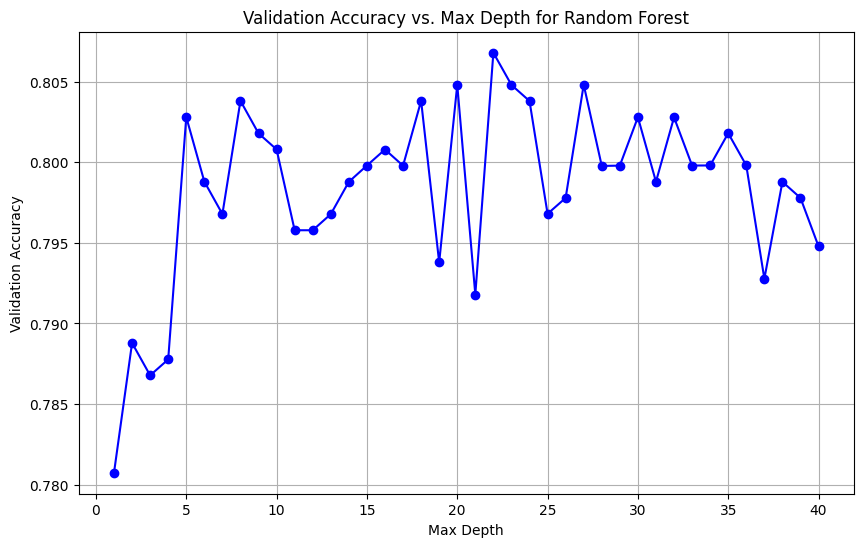

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)
depths = range(1, 41)  
fixed_min_samples_leaf = 10

val_accuracies = []
best_cv_score = -np.inf
best_params = None

for depth in depths:
    params['max_depth'] = depth 
    params['min_samples_leaf'] = fixed_min_samples_leaf
    
    rf_temp = RandomForest(params=params, n=N, m=int(np.sqrt(X.shape[1])))
    cv_scores = cross_val_score(rf_temp, X, y, cv=5)
    avg_cv_score = np.mean(cv_scores)
    val_accuracies.append(avg_cv_score)

    print(f"max_depth: {depth}, min_samples_leaf: {fixed_min_samples_leaf}, CV Score: {avg_cv_score:.4f}")

    if avg_cv_score > best_cv_score:
        best_cv_score = avg_cv_score
        best_params = (depth, fixed_min_samples_leaf)

best_depth = depths[np.argmax(val_accuracies)]
best_accuracy = max(val_accuracies)
print(f"\nBest Hyperparameters:")
print(f"max_depth: {best_params[0]}, min_samples_leaf: {best_params[1]}, with CV Score: {best_cv_score:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(depths, val_accuracies, marker='o', linestyle='-', color='blue')
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Max Depth for Random Forest")
plt.grid(True)
plt.show()
